# 1. Install and Import Dependencies

In [1]:
#INSTALL

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install stable-baselines3[extra] protobuf==3.20.*
!pip install Pillow
!pip install pytesseract
!pip install mss pydirectinput pytesseract
!pip install gym

Looking in indexes: https://download.pytorch.org/whl/cu121


In [21]:
#IMPORT

from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

pytesseract.pytesseract.tesseract_cmd = 'C:\\Users\\maria\\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe'

# 2. Build the Environment

## 2.1 Create Environment

In [22]:
# CREATE ENVIRONMENT

class WebGame(Env):
    def __init__(self):
        
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 300, 'height': 70}
        
    def step(self, action):
        action_dict = { 0:'space', 1:'down', 2:'no_op'}
        #print(action)
        if action !=2:
            pydirectinput.press(action_dict[action])

        done, done_capt = self.get_done() 
        new_obs = self.get_observation()
        
        reward = 1
        
        if action==2:
            reward = 2
        
        info = {}
        
        return new_obs, reward, done, info
    
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
            
    def close(self):
        cv2.destroyAllWindows()
            
    def reset(self):
        
        #time.sleep(1)
        
        pydirectinput.click(x=150, y=150)
        
        pydirectinput.press('space')
        
        #info={}
        
        return self.get_observation()
        
    
    def get_observation(self):
        
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        
        return channel
    
    def get_done(self):
        
        done_cap = np.array(self.cap.grab(self.done_location))
        
        done_strings = ["G"]
        
        done = False
        
        res = pytesseract.image_to_string(done_cap)[:1]
        if res in done_strings:
            done = True

#         done=False
    
#         print(done_cap[0][0])
        
#         if done_cap[0][0]==np.array([172, 172, 172, 255]):
#             done==True

        return done, done_cap

# 2.2 Test Environment

In [23]:
env = WebGame()
done, done_cap=env.get_done()

In [64]:
pytesseract.image_to_string(done_cap)

'GAME\n'

In [65]:
done

True

In [54]:
#TEST

for i in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, tr, inf =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

Total Reward for episode 0 is 16
Total Reward for episode 1 is 15
Total Reward for episode 2 is 13
Total Reward for episode 3 is 13
Total Reward for episode 4 is 13
Total Reward for episode 5 is 13
Total Reward for episode 6 is 14
Total Reward for episode 7 is 11
Total Reward for episode 8 is 13
Total Reward for episode 9 is 15


# 3. Train the Model

## 3.1 Create Callback

In [24]:
#CREATE CALLBACK

import os 

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [25]:
#env_checker.check_env(env)

In [26]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [27]:
CHECKPOINT_DIR = "C:\\Users\\maria\\Documents\\Pseudo Desktop\\Uni\\CSCI218\\DINO MODELS\\DINO_CHROME_WORKS\\DINO1\\train"
LOG_DIR = "C:\\Users\\maria\\Documents\\Pseudo Desktop\\Uni\\CSCI218\\DINO MODELS\\DINO_CHROME_WORKS\\DINO1\\logs"

callback = TrainAndLoggingCallback(check_freq=100, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [28]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [29]:
env = WebGame()

In [30]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1000, learning_starts=0)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [20]:
model.learn(total_timesteps=100, callback=callback)

Logging to C:\Users\maria\Documents\Pseudo Desktop\Uni\CSCI218\DINO MODELS\DINO_CHROME_WORKS\DINO1\logs\DQN_9
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9        |
|    ep_rew_mean      | 13       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 15       |
|    total_timesteps  | 36       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.62     |
|    ep_rew_mean      | 13.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 33       |
|    total_timesteps  | 77       |
----------------------------------


In [31]:
model.load('C:\\Users\\maria\\Documents\\Pseudo Desktop\\Uni\\CSCI218\\DINO MODELS\\DINO_CHROME_WORKS\\DINO1\\train\\best_model_30000.zip')

In [32]:
model = DQN.load('C:\\Users\\maria\\Documents\\Pseudo Desktop\\Uni\\CSCI218\\DINO MODELS\\DINO_CHROME_WORKS\\DINO1\\train\\best_model_30000.zip')

In [33]:
#FINAL

for episode in range(4): 
    observation = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(observation)
        observation, reward, done, info = env.step(int(action))
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode+1, total_reward))
    time.sleep(1)


Total Reward for episode 1 is 67
Total Reward for episode 2 is 63
Total Reward for episode 3 is 120
Total Reward for episode 4 is 62


In [16]:
env = WebGame()
done, done_cap =env.get_done()
done

True

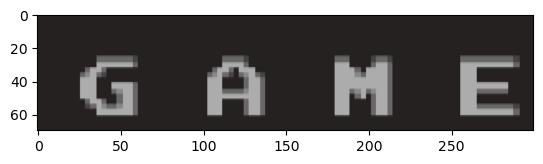

In [66]:
plt.imshow(done_cap)

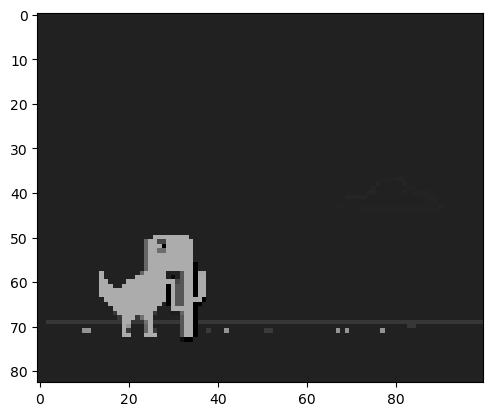

In [53]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))